# Latest improvement

## Imports

In [1]:
import numpy as np
import random
import heapq
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Environment

## Dijikstra Agent

In [10]:
class DijkstraAgent:
    """
    An agent that uses Dijkstra's algorithm to navigate the DisasterZoneEnv.
    """

    def __init__(self, env):
        self.env = env
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def dijkstra(self, grid, start, target):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        pq = [(0, start)]
        distances = {start: 0}
        previous = {start: None}

        while pq:
            current_distance, current_position = heapq.heappop(pq)
            if current_position == target:
                # Reconstruct path
                path = []
                while current_position is not None:
                    path.append(current_position)
                    current_position = previous[current_position]
                path.reverse()
                return path, current_distance

            for dx, dy in directions:
                nx = current_position[0] + dx
                ny = current_position[1] + dy
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
                    if grid[nx, ny] != 1:  # not an obstacle
                        new_dist = current_distance + 1
                        if (nx, ny) not in distances or new_dist < distances[(nx, ny)]:
                            distances[(nx, ny)] = new_dist
                            previous[(nx, ny)] = current_position
                            heapq.heappush(pq, (new_dist, (nx, ny)))

        print(f"No path found from {start} to {target}")
        return [], float('inf')

    def find_closest_target(self, target_type):
        start = (self.env.drone_x, self.env.drone_y)
        targets = [(x, y) for x in range(self.env.height)
                   for y in range(self.env.width)
                   if self.env.grid[x, y] == target_type]

        if not targets:
            print(f"No targets of type {target_type} found!")
            return None, None, float('inf')

        best_distance = float('inf')
        best_path = None
        best_target = None
        for t in targets:
            path, dist = self.dijkstra(self.env.grid, start, t)
            if dist < best_distance:
                best_distance = dist
                best_path = path
                best_target = t

        return best_path, best_target, best_distance

    def execute(self):
        step_count = 0
        while self.env.energy > 0:
            # Look for survivors first
            path, target_pos, _ = self.find_closest_target(2)
            if not path:
                # Then look for resources if no survivors
                path, target_pos, _ = self.find_closest_target(3)

            if not path:
                print("No reachable targets. Stopping.")
                break

            # Move step by step (path[0] is current pos, so start from path[1])
            for step in path[1:]:
                self.env.drone_x, self.env.drone_y = step
                self.steps_taken += 1
                step_count += 1

                # If dynamic is True, apply changes
                if self.env.dynamic:
                    self.env.apply_dynamic_changes(step_count)

                self.env.energy -= 1
                if self.env.energy <= 0:
                    break

            # If we reached the target
            if target_pos:
                cell_val = self.env.grid[target_pos[0], target_pos[1]]
                if cell_val == 2:
                    self.survivors_rescued += 1
                elif cell_val == 3:
                    self.resources_collected += 1
                self.env.grid[target_pos[0], target_pos[1]] = 0

## Scenarios to test

In [11]:
SCENARIOS_DICT = {
    # Keep or remove your original ones:
    "Scenario_1": {
        "name": "Simple Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 2, 0, 1, 0, 0, 3, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [3, 0, 0, 0, 0, 0, 0, 'D']
        ], dtype=object),
        "dynamic": False,
        "description": "Minimal obstacles, static environment"
    },
    "Scenario_2": {
        "name": "Obstacle Maze",
        "grid": np.array([
            [0, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 2, 1, 0, 1, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 3],
            [0, 1, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 0, 2, 0],
            ['D', 1, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A more complex layout with many obstacles"
    },
    "Scenario_3": {
        "name": "Dynamic Mixed Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 3, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 2, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 3, 0, 0, 0, 0],
            ['D', 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "Tests dynamic obstacle creation and survivor movement"
    },

    # ---------------------------------------------------
    #  NEW, More Comprehensive Scenarios
    # ---------------------------------------------------

    "Scenario_4": {
        "name": "Large Static 10x10",
        "grid": np.array([
            [0, 0, 1, 0, 0, 0, 0, 3, 0, 0],
            [0, 2, 0, 1, 0, 0, 0, 0, 0, 0],
            [1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 3, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
            [0, 2, 0, 0, 1, 0, 0, 3, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
            [0, 1, 1, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
            ['D', 0, 0, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A larger 10x10 grid, static obstacles and multiple resources"
    },

    "Scenario_5": {
        "name": "Large Dynamic 10x10",
        "grid": np.array([
            [0, 0, 1, 0, 0, 0, 0, 3, 2, 0],
            [0, 2, 0, 1, 0, 0, 0, 0, 1, 0],
            [1, 1, 1, 0, 3, 0, 0, 0, 0, 0],
            [0, 0, 0, 2, 0, 3, 0, 0, 0, 0],
            [0, 0, 0, 1, 1, 1, 0, 0, 2, 0],
            [0, 2, 0, 0, 1, 0, 0, 3, 0, 1],
            [0, 0, 3, 0, 0, 0, 0, 0, 2, 1],
            [2, 1, 1, 0, 0, 0, 0, 2, 0, 0],
            [0, 0, 0, 3, 0, 0, 1, 0, 0, 0],
            ['D', 0, 0, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "A larger 10x10 with multiple survivors, resources, obstacles, and dynamic updates"
    },

    "Scenario_6": {
        "name": "12x12 Full Maze",
        "grid": np.array([
            [1, 1, 1, 1, 1, 0, 0, 0, 3, 0, 1, 1],
            [1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
            [1, 3, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
            [1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 3, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
            [1, 0, 3, 0, 1, 0, 0, 1, 0, 1, 0, 1],
            [1, 0, 0, 0, 1, 2, 0, 1, 3, 0, 0, 1],
            ['D', 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        ], dtype=object),
        "dynamic": False,
        "description": "12x12 large maze with many obstacles, multiple survivors, resources"
    },

    "Scenario_7": {
        "name": "12x12 Partially Dynamic Maze",
        "grid": np.array([
            [1, 1, 1, 1, 1, 0, 0, 0, 3, 0, 1, 1],
            [1, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
            [1, 3, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
            [1, 2, 1, 1, 1, 1, 0, 0, 0, 1, 3, 1],
            [1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1],
            [1, 0, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1],
            [1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1],
            [1, 0, 3, 0, 1, 0, 0, 1, 0, 1, 0, 1],
            [1, 0, 0, 0, 1, 2, 0, 1, 3, 0, 0, 1],
            ['D', 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
        ], dtype=object),
        "dynamic": True,
        "description": "12x12 large maze with partial dynamic changes (obstacles & survivors move)"
    },
}


## Testing class for all agents

In [12]:
class Tester:
    """
    Handles scenario-based testing and metric collection for multiple agents.
    """

    def __init__(self, agent_classes, scenarios_dict, env_params=None):
        """
        :param agent_classes: List of agent classes [DijkstraAgent, AStarAgent, QLearningAgent, ...]
        :param scenarios_dict: Dictionary of scenarios with 'grid', 'dynamic', etc.
        :param env_params: Global environment params (width, height, initial_energy, seed, etc.)
        """
        self.agent_classes = agent_classes
        self.scenarios_dict = scenarios_dict
        self.env_params = env_params if env_params else {}
        self.results = []

    def run_all_scenarios(self):
        """
        Iterate over each scenario, test each agent, store results.
        """
        for scenario_id, scenario_info in self.scenarios_dict.items():
            scenario_grid = scenario_info["grid"]
            scenario_name = scenario_info.get("name", scenario_id)
            scenario_dynamic = scenario_info.get("dynamic", False)
            scenario_desc = scenario_info.get("description", "")

            for agent_class in self.agent_classes:
                # Merge scenario dynamic with global env_params
                # If scenario explicitly says dynamic, it overrides global setting
                merged_dynamic = scenario_dynamic  
                merged_initial_energy = self.env_params.get("initial_energy", 20)
                merged_seed = self.env_params.get("seed", None)
                merged_recharge_amount = self.env_params.get("recharge_amount", None)

                # Instantiate environment
                env = DisasterZoneEnv(
                    predefined_grid=scenario_grid,
                    width=self.env_params.get('width', 8),
                    height=self.env_params.get('height', 8),
                    initial_energy=merged_initial_energy,
                    dynamic=merged_dynamic,
                    seed=merged_seed,
                    recharge_amount=merged_recharge_amount
                )

                # Create agent
                agent = agent_class(env)

                # Run
                start_time = time.time()
                agent.execute()
                end_time = time.time()

                comp_time = end_time - start_time

                # Record metrics
                self.results.append({
                    "Scenario ID": scenario_id,
                    "Scenario Name": scenario_name,
                    "Is Dynamic": merged_dynamic,
                    "Agent Name": agent_class.__name__,
                    "Steps Taken": getattr(agent, "steps_taken", None),
                    "Survivors Rescued": getattr(agent, "survivors_rescued", None),
                    "Resources Collected": getattr(agent, "resources_collected", None),
                    "Energy Used": merged_initial_energy - env.energy,
                    "Computation Time (s)": comp_time,
                    "Description": scenario_desc
                })

    # def save_results(self, filename="results.csv"):
    #     df = pd.DataFrame(self.results)
    #     df.to_csv(filename, index=False)
    #     print(f"Results saved to {filename}")

    def get_results_df(self):
        """
        Return results as a DataFrame for further usage (plotting, analysis).
        """
        return pd.DataFrame(self.results)

# Running the scenarios

No targets of type 2 found!
No targets of type 2 found!
No targets of type 2 found!
No path found from (9, 0) to (1, 1)
No path found from (5, 1) to (1, 1)
No path found from (7, 7) to (1, 1)
No path found from (5, 7) to (1, 1)
No path found from (3, 5) to (1, 1)
No path found from (9, 0) to (1, 1)
No path found from (7, 0) to (1, 1)
No path found from (1, 4) to (0, 0)
No path found from (11, 0) to (1, 6)
No path found from (11, 0) to (5, 1)
No path found from (11, 0) to (7, 8)
No path found from (11, 0) to (10, 5)
No path found from (11, 0) to (0, 8)
No path found from (11, 0) to (3, 1)
No path found from (11, 0) to (5, 10)
No path found from (11, 0) to (9, 2)
No path found from (11, 0) to (10, 8)
No reachable targets. Stopping.
No path found from (11, 0) to (1, 6)
No path found from (11, 0) to (5, 1)
No path found from (11, 0) to (7, 8)
No path found from (11, 0) to (10, 5)
No path found from (11, 0) to (0, 8)
No path found from (11, 0) to (3, 1)
No path found from (11, 0) to (5, 10)

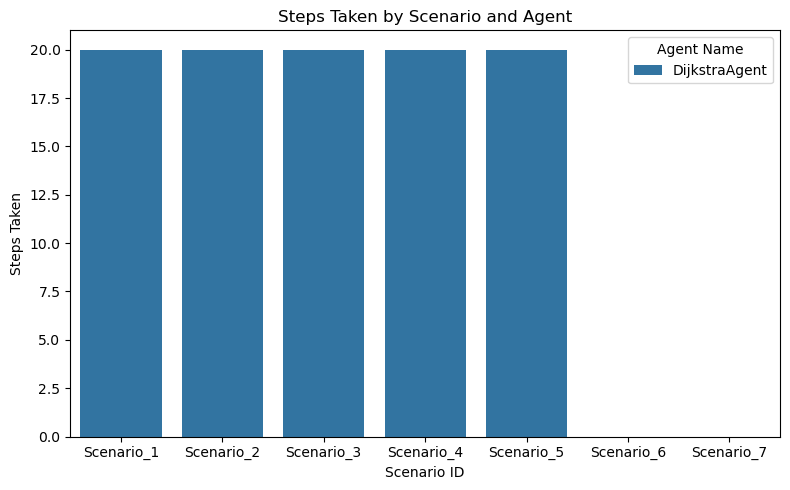

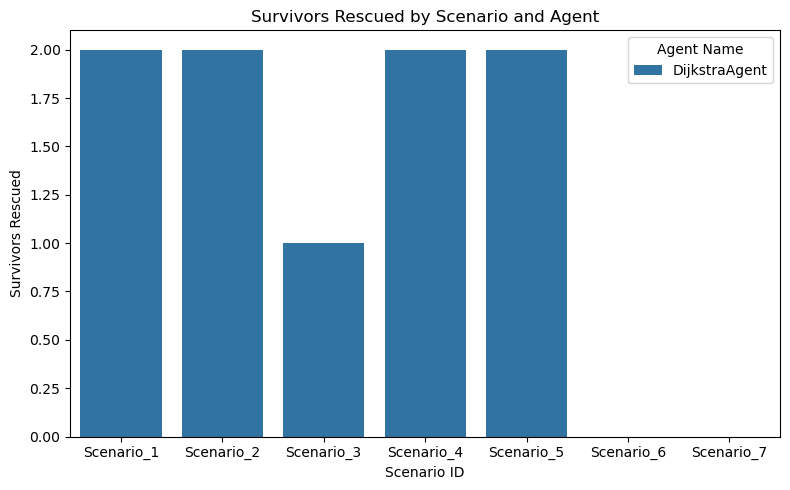

In [13]:
# If you had multiple agents, you'd list them here, e.g. [DijkstraAgent, AStarAgent]
agent_list = [DijkstraAgent]

# Global environment parameters:
env_params = {
    "initial_energy": 20,
    "seed": 42,              # for reproducibility
    "recharge_amount": None  # full recharge if collecting resource
}

tester = Tester(
    agent_classes=agent_list,
    scenarios_dict=SCENARIOS_DICT,
    env_params=env_params
)

# Run all scenarios
tester.run_all_scenarios()

# Save results
# tester.save_results("results.csv")

# Retrieve results as a DataFrame
df_results = tester.get_results_df()
print(df_results)

# Plotting Examples
plt.figure(figsize=(8, 5))
sns.barplot(data=df_results, x="Scenario ID", y="Steps Taken", hue="Agent Name")
plt.title("Steps Taken by Scenario and Agent")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=df_results, x="Scenario ID", y="Survivors Rescued", hue="Agent Name")
plt.title("Survivors Rescued by Scenario and Agent")
plt.tight_layout()
plt.show()

In [14]:
print(df_results["Scenario ID"].unique())

['Scenario_1' 'Scenario_2' 'Scenario_3' 'Scenario_4' 'Scenario_5'
 'Scenario_6' 'Scenario_7']
